# Go Emotions Wrangling
- Explore dataset (NaNs, Duplications)
- Clean (remove unwanted rows)
- Make dummy variables for modelling
- Save into new Dataset for EDA

In [13]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [14]:
# read in data, three different csv files
emo_raw1 = pd.read_csv('https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv')
emo_raw2 = pd.read_csv('https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_2.csv')
emo_raw3 = pd.read_csv('https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_3.csv')

In [15]:
# concat csv files into one big dataframe
emo_full_raw = pd.concat([emo_raw1, emo_raw2, emo_raw3]).reset_index(drop=True)

In [16]:
# set column display option, so i can read the full comment in the text column
pd.set_option('display.max_colwidth', None)
# check contents of first 5 rows
emo_full_raw.head()

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,eew5j0j,Brdd9,nrl,t3_ajis4z,t1_eew18eq,1.548381e+09,1,False,0,...,0,0,0,0,0,0,0,1,0,0
1,">sexuality shouldn’t be a grouping category It makes you different from othet ppl so imo it fits the definition of ""grouping""",eemcysk,TheGreen888,unpopularopinion,t3_ai4q37,t3_ai4q37,1.548084e+09,37,True,0,...,0,0,0,0,0,0,0,0,0,0
2,"You do right, if you don't care then fuck 'em!",ed2mah1,Labalool,confessions,t3_abru74,t1_ed2m7g7,1.546428e+09,37,False,0,...,0,0,0,0,0,0,0,0,0,1
3,Man I love reddit.,eeibobj,MrsRobertshaw,facepalm,t3_ahulml,t3_ahulml,1.547965e+09,18,False,0,...,1,0,0,0,0,0,0,0,0,0
4,"[NAME] was nowhere near them, he was by the Falcon.",eda6yn6,American_Fascist713,starwarsspeculation,t3_ackt2f,t1_eda65q2,1.546669e+09,2,False,0,...,0,0,0,0,0,0,0,0,0,1


## The Dataset
The simplified configuration includes: <br>

text: the reddit comment<br>
labels: the emotion annotations<br>
comment_id: unique identifier of the comment (can be used to look up the entry in the raw dataset)<br>


In addition to the above, the raw data includes:<br>


author: The Reddit username of the comment's author.<br>
subreddit: The subreddit that the comment belongs to.<br>
link_id: The link id of the comment.<br>
parent_id: The parent id of the comment.<br>
created_utc: The timestamp of the comment.<br>
rater_id: The unique id of the annotator.<br>
example_very_unclear: Whether the annotator marked the example as being very unclear or difficult to label (in this case they did not choose any emotion labels). <br>
In the raw data, labels are listed as their own columns with binary 0/1 entries rather than a list of ids as in the simplified data.


### From the GoEmotions Paper
- comments labeled for one or more 27 emotions or Neutral
- from subreddits with atleast 10k comments (english)
- removed NSFW subreddits and subreddits where 10%+ comments were offensive
- manually reviewed for racist/sexist comments
- applied NLTKs word tokensizer to select comments 3-30 tokens long (including punctuation)

In [17]:
emo_full_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211225 entries, 0 to 211224
Data columns (total 37 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   text                  211225 non-null  object 
 1   id                    211225 non-null  object 
 2   author                211225 non-null  object 
 3   subreddit             211225 non-null  object 
 4   link_id               211225 non-null  object 
 5   parent_id             211225 non-null  object 
 6   created_utc           211225 non-null  float64
 7   rater_id              211225 non-null  int64  
 8   example_very_unclear  211225 non-null  bool   
 9   admiration            211225 non-null  int64  
 10  amusement             211225 non-null  int64  
 11  anger                 211225 non-null  int64  
 12  annoyance             211225 non-null  int64  
 13  approval              211225 non-null  int64  
 14  caring                211225 non-null  int64  
 15  

In [18]:
# count unique comments
emo_full_raw['id'].nunique()

58011

The raw dataset contains 211225 Rows of data and 58011 unique comments <br>
Each row of data is a comment that is annotated for emotion(s) from a reviewer. <br>
What i want to do is aggregate the annotations per comment and score it for positve/negative sentiments <br>
To end up with 58011 rows of data, instead of duplicates of each unique comment <br>

In [19]:
# make a subset with just comment ID and emotions, sum the emotions per comment, inner join table later, drop duplicates?
emo_comment_agg = emo_full_raw.iloc[:, np.r_[1,9:37]].copy()

In [20]:
emo_comment_agg.head()

,id,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,eew5j0j,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,eemcysk,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ed2mah1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,eeibobj,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,eda6yn6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [21]:
# group by comment id, sum up emotions
emo_comment_agg = pd.DataFrame(emo_comment_agg.groupby('id').sum())

In [22]:
# look at dataframe
emo_comment_agg.head()

,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
id,,,,,,,,,,,,,,,,,,,,,
eczazk6,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
eczb07q,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
eczb4bm,0,0,0,0,0,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
eczb527,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
eczb6r7,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,2


In [23]:
# make a totals columns to explore how many emotions per comment we have, on average
emo_comment_agg['total'] = emo_comment_agg.iloc[:,0:].sum(axis=1)

emo_comment_agg['total'].describe()

count    58011.000000
mean         4.301408
std          1.483686
min          0.000000
25%          3.000000
50%          4.000000
75%          5.000000
max         16.000000
Name: total, dtype: float64

On average, there are 16 emotions per comment when I total them all up. This is accounting for multiple reviewers. <br>
I want to bring these values back to 1 or 0. <br>
- make a for loop to loop over columns, if there is a value of 2 or greater, make it into 1
- if there is a value less than 2, turn the value into a 0
- this ensures that an emotion is only kept if mutliple reviewers agreed on the emotion


In [24]:
### for loop, loop over columns and replace >2 with 1, else 0

for col in emo_comment_agg.columns:
    emo_comment_agg[col] = np.where(emo_comment_agg[col] >= 2, 1, 0)

In [25]:
emo_comment_agg.sum()

admiration         5122
amusement          2895
anger              1960
annoyance          3093
approval           3687
caring             1375
confusion          1673
curiosity          2723
desire              801
disappointment     1583
disapproval        2581
disgust            1013
embarrassment       375
excitement         1052
fear                764
gratitude          3372
grief                96
joy                1785
love               2576
nervousness         208
optimism           1976
pride               142
realization        1382
relief              182
remorse             669
sadness            1625
surprise           1330
neutral           17772
total             57896
dtype: int64

In [26]:
emo_comment_agg.reset_index()

,id,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral,total
0,eczazk6,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,eczb07q,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2,eczb4bm,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,eczb527,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,eczb6r7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58006,efhclgb,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
58007,efhcm78,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
58008,efhcnhz,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
58009,efhcreo,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [27]:
# remake the total column
emo_comment_agg['total'] = emo_comment_agg.iloc[:,1:].sum(axis=1)

# view the total column stats after the for loop
emo_comment_agg['total'].describe()

count    58011.000000
mean         2.009722
std          0.531356
min          0.000000
25%          2.000000
50%          2.000000
75%          2.000000
max          6.000000
Name: total, dtype: float64

The mean is now ~1.9 emotions per comment. <br>
I will join left join the original dataframe on 'id' to preserve the new annotation numbers and just bring in the comments/subreddit

In [28]:
# subset dataframe with comments/subreddit/id

textsubid_df = emo_full_raw.loc[:, ['text', 'subreddit', 'id']].copy()

In [29]:
# drop duplicate columns, this should drop multiple comment ids for each reviewer
textsubid_df.drop_duplicates(inplace=True)

In [30]:
# look at dataframe
textsubid_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58011 entries, 0 to 211161
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       58011 non-null  object
 1   subreddit  58011 non-null  object
 2   id         58011 non-null  object
dtypes: object(3)
memory usage: 1.8+ MB


When I droped duplicates of the dataframe with just comments and comment ids, i got back the original unique comment number 58011 (so i can join this with the correctly scored dataframe)

In [31]:
# merge aggregated dataframe
Goemo_model_df  = pd.merge(emo_comment_agg, textsubid_df, how="inner", on=["id"])

In [32]:
# check
Goemo_model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58011 entries, 0 to 58010
Data columns (total 32 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              58011 non-null  object
 1   admiration      58011 non-null  int32 
 2   amusement       58011 non-null  int32 
 3   anger           58011 non-null  int32 
 4   annoyance       58011 non-null  int32 
 5   approval        58011 non-null  int32 
 6   caring          58011 non-null  int32 
 7   confusion       58011 non-null  int32 
 8   curiosity       58011 non-null  int32 
 9   desire          58011 non-null  int32 
 10  disappointment  58011 non-null  int32 
 11  disapproval     58011 non-null  int32 
 12  disgust         58011 non-null  int32 
 13  embarrassment   58011 non-null  int32 
 14  excitement      58011 non-null  int32 
 15  fear            58011 non-null  int32 
 16  gratitude       58011 non-null  int32 
 17  grief           58011 non-null  int32 
 18  joy   

There were 58011 unqiue comments in the original full raw dataframe, I now have that same number but in rows <br>
I believe my aggregating method worked

In [33]:
# rearrange columns < - df.iloc[:, np.r_[]].copy()
Goemo_model_df = Goemo_model_df.iloc[:, np.r_[0,30,31,1:30]].copy()


In [34]:
Goemo_model_df.head()

,id,text,subreddit,admiration,amusement,anger,annoyance,approval,caring,confusion,...,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral,total
0,eczazk6,Fast as [NAME] will carry me. Seriously uptown to downtown via Claiborne or broad isn’t that bad,NewOrleans,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,2
1,eczb07q,You blew it. They played you like a fiddle.,self,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2
2,eczb4bm,TL;DR No more Superbowls for [NAME]. Get ready for another winning season that ends in disappointment.,steelers,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,eczb527,So much time saved. Not.,Roadcam,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
4,eczb6r7,"Emotes have a ridiculous amount of effort put into them, which only makes the fact that nobody uses them sadder",Blackops4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2


### More Wrangling
I will explore the features of this dataframe and futher clean it further <br>
Things to check:
- overall emotions correlations
- what does neutral look like?
- are there comments with 0 emotion scores?


<AxesSubplot:>

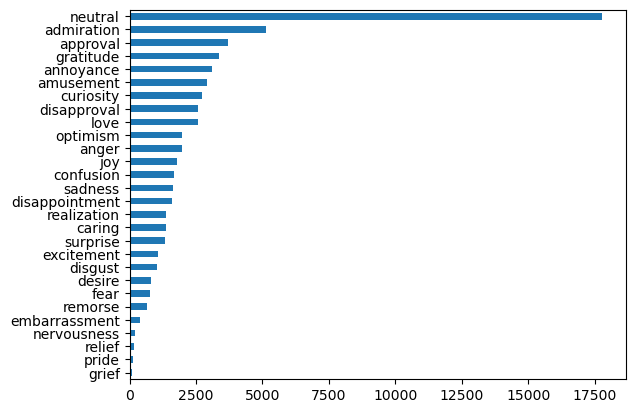

In [35]:
# select numeric columns into new dataset to view features
numeric = Goemo_model_df.iloc[:, 3:31]

# count the number of rows that have a neutral point
numeric.sum().sort_values(ascending = True).plot(kind = 'barh')

In [36]:
numeric.sum().sort_values(ascending = False)

neutral           17772
admiration         5122
approval           3687
gratitude          3372
annoyance          3093
amusement          2895
curiosity          2723
disapproval        2581
love               2576
optimism           1976
anger              1960
joy                1785
confusion          1673
sadness            1625
disappointment     1583
realization        1382
caring             1375
surprise           1330
excitement         1052
disgust            1013
desire              801
fear                764
remorse             669
embarrassment       375
nervousness         208
relief              182
pride               142
grief                96
dtype: int64

Neutral seems to be the highest emotions. <br>
After my aggregation of the dataset, it also seems to be associated with some rows that have emotions <br>
Maybe i will score the positive/negative/ambiguous columns and then assign a new neutral column to rows that do not have a value in these new sentiment columns


admiration, approval, and annoyance are emotions that are most represented in this dataset <br>
grief, relief, and pride are the least represented

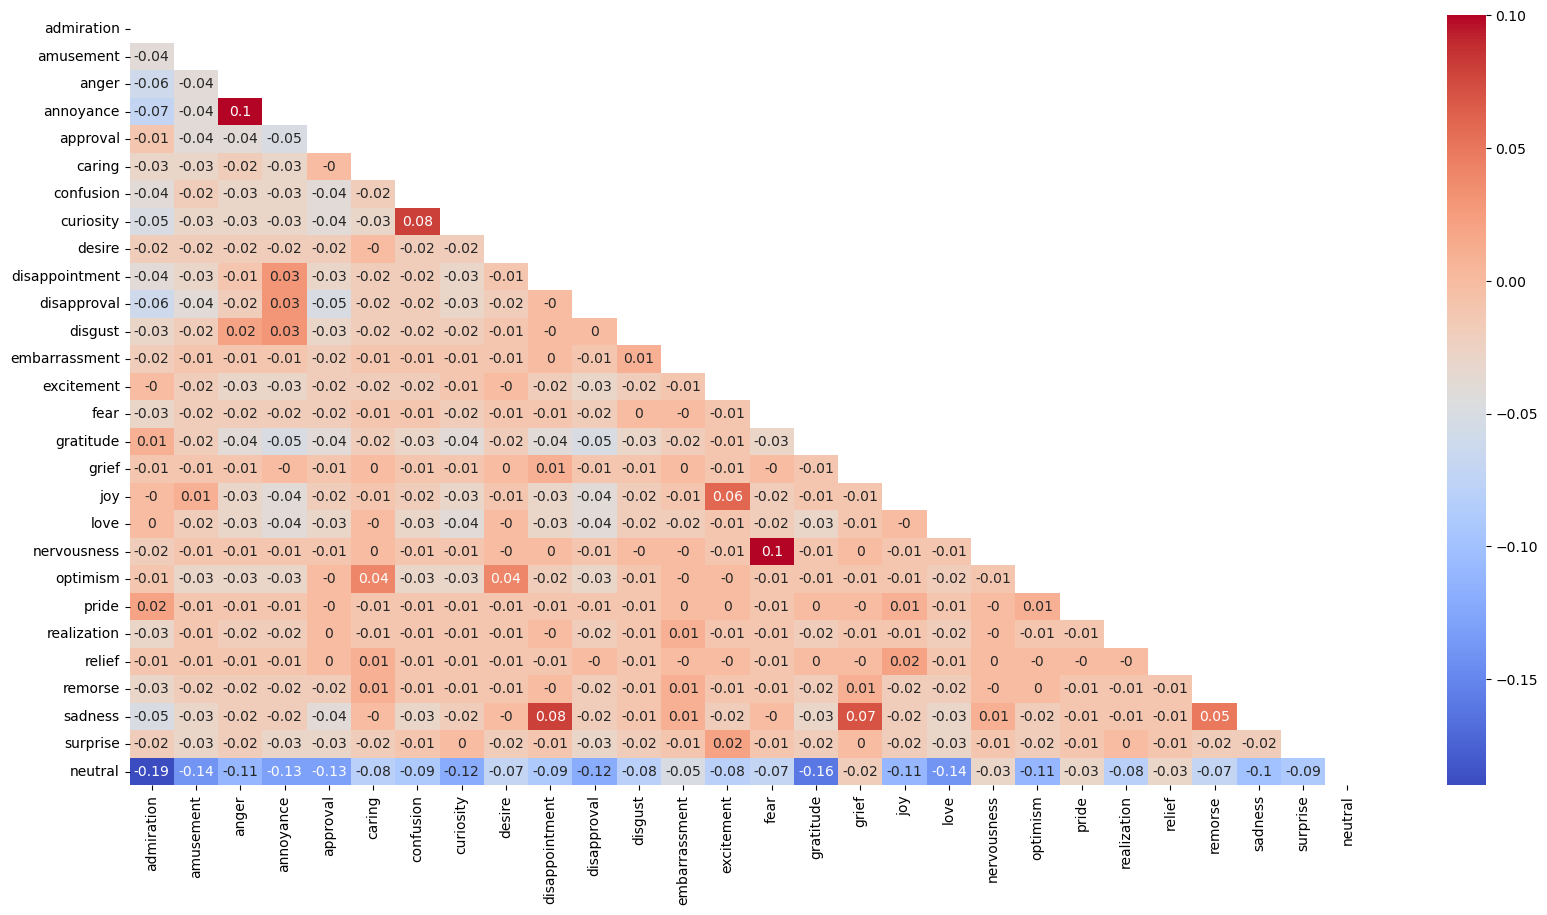

In [37]:
import seaborn as sns

plt.figure(figsize = (20,10))
sns.heatmap(numeric.corr().round(2), annot = True, cmap = 'coolwarm', mask = np.triu(numeric.corr()))
plt.show()

There are no strong correlations of emotions in the dataset. All correlations are < 0.2 <br>
However, some emotions stand out:
- annoyance and anger 
- confusion and curiosity
- fear and nervousness
- disappointment and sadness
- neutral


Check to see if there are comments with no emotions
- Where 'total' = 0

In [38]:
# count columns with no values for any emotion
Goemo_model_df[Goemo_model_df['total'] == 0].shape

(115, 32)

There are 115 comments with no associated emotion. I will drop these

In [39]:
# drop comments with no emotions
Goemo_model_df.drop(Goemo_model_df.index[Goemo_model_df['total'] == 0], inplace = True)

# reset index, drop old index
Goemo_model_df.reset_index(inplace = True, drop = True)

# check 
Goemo_model_df.shape

(57896, 32)

#### Checkpoint

Concatenated all csv files into one large dataset
- aggregated on comment id
    - sum'd' up emotional annotation scores
    - changed emotion scores to binary (if previous was greater than 2, change to 1, else 0)
        - if two reviewers both annoted a comment for an emotion, it stayed
- remade new dataframe with unqiue ids/comments
    - started exploring
    - greif/relief/pride are under represented emotions
    - approval/adirmation/annoyance are top 3 emotions
- droped rows/comments with 0 values for any emotion
    - we now have 57896 rows


Next steps
- score comments as positive/negative/ or ambiguous
- emotion categories from 'https://ai.googleblog.com/2021/10/goemotions-dataset-for-fine-grained.html'

![emotion](https://blogger.googleusercontent.com/img/a/AVvXsEigu_MmQ7zbqciHaEAl_rjZYNEPX6GyGEh9nkIoGOaMUg3BPCizBGJc-FhAMluHZHVX2cArth_0RgQVaEELUT3Y4oWv3V1h_ES5YjNxXJPre5YZy_2bG7ihLKjKOrQJTjEM-9SFLTFq6-Beo94ZS7yqslE-VFOH4xRlUX35rBVYtPskYGIv4DbBRiL08Q=s16000)

Score each comment/row as a positive/negative/ambiguous <br>


Overall Strategy:
- create new dataframe with just postive or negative or ambiguous columns
- attach a score on a new column, append that column to our original dataframe

In [40]:
# dictionary of emotions assocaited with positive/negative/ambiguous emotions. Pulled from paper

emo_dict = {
"positive": ["amusement", "excitement", "joy", "love", "desire", 
             "optimism", "caring", "pride", "admiration", "gratitude", "relief", "approval"],
"negative": ["fear", "nervousness", "remorse", "embarrassment", 
             "disappointment", "sadness", "grief", "disgust", "anger", "annoyance", "disapproval"],
"ambiguous": ["realization", "surprise", "curiosity", "confusion"]
}

In [41]:
# create new dataframe based on dictionary list
# df2 = df1[df1.columns[df1.columns.isin(my_list)]]
positive = Goemo_model_df[Goemo_model_df.columns[Goemo_model_df.columns.isin(emo_dict['positive'])]].copy()

# check new dataframe columns
positive.columns

Index(['admiration', 'amusement', 'approval', 'caring', 'desire', 'excitement',
       'gratitude', 'joy', 'love', 'optimism', 'pride', 'relief'],
      dtype='object')

In [42]:
# make a totals column in new dataframe, rowise addition
positive['total'] = positive.sum(axis=1)

# make a positive column, 1 if there is a value in the totals column
positive['positive'] = np.where(positive['total'] >= 1, 1, 0)

#check
positive.head(7)

,admiration,amusement,approval,caring,desire,excitement,gratitude,joy,love,optimism,pride,relief,total,positive
0,0,0,1,0,0,0,0,0,0,0,0,0,1,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,1,0,0,0,0,0,1,1


for rows 0 and 6. there is a value in the total column and therefore a value of 1 in the 'positive' column

In [43]:
positive[positive['total'] > 0].sum()

admiration     5122
amusement      2895
approval       3687
caring         1375
desire          801
excitement     1052
gratitude      3372
joy            1785
love           2576
optimism       1976
pride           142
relief          182
total         24965
positive      21733
dtype: int64

21733 comments are labeled as positive in the dataset

In [44]:
# copy same process for negative comments
negative = Goemo_model_df[Goemo_model_df.columns[Goemo_model_df.columns.isin(emo_dict['negative'])]].copy()

# make a totals column in new dataframe, rowise addition
negative['total'] = negative.sum(axis=1)

# make a begative column, 1 if there is a value in the totals column
negative['negative'] = np.where(negative['total'] >= 1, 1, 0)

#check
negative.head(7)

,anger,annoyance,disappointment,disapproval,disgust,embarrassment,fear,grief,nervousness,remorse,sadness,total,negative
0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,1,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,1,2,1
6,0,0,0,0,0,0,0,0,0,0,0,0,0


row 2 and 5 have a total value, therefore they have a 1 in the 'negative' column

In [45]:
negative[negative['total'] > 0].sum()

anger              1960
annoyance          3093
disappointment     1583
disapproval        2581
disgust            1013
embarrassment       375
fear                764
grief                96
nervousness         208
remorse             669
sadness            1625
total             13967
negative          12342
dtype: int64

12342 comments are labeled as negative in the dataset

In [46]:
# copy same process for ambiguous comments
ambiguous = Goemo_model_df[Goemo_model_df.columns[Goemo_model_df.columns.isin(emo_dict['ambiguous'])]].copy()

# make a totals column in new dataframe, rowise addition
ambiguous['total'] = ambiguous.sum(axis=1)

# make a ambiguous column, 1 if there is a value in the totals column
ambiguous['ambiguous'] = np.where(ambiguous['total'] >= 1, 1, 0)

#check
ambiguous[ambiguous['total'] > 0].sum()

confusion      1673
curiosity      2723
realization    1382
surprise       1330
total          7108
ambiguous      6668
dtype: int64

there are 6668 comments labeled as ambiguous in the dataset

In [47]:
# append these columns to the old dataset
Goemo_model_df['positive'] = positive['positive']
Goemo_model_df['negative'] = negative['negative']
Goemo_model_df['ambiguous'] = ambiguous['ambiguous']

In [48]:
Goemo_model_df.head(8)

,id,text,subreddit,admiration,amusement,anger,annoyance,approval,caring,confusion,...,realization,relief,remorse,sadness,surprise,neutral,total,positive,negative,ambiguous
0,eczazk6,Fast as [NAME] will carry me. Seriously uptown to downtown via Claiborne or broad isn’t that bad,NewOrleans,0,0,0,0,1,0,0,...,0,0,0,0,0,0,2,1,0,0
1,eczb07q,You blew it. They played you like a fiddle.,self,0,0,0,0,0,0,0,...,0,0,0,0,0,1,2,0,0,0
2,eczb4bm,TL;DR No more Superbowls for [NAME]. Get ready for another winning season that ends in disappointment.,steelers,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,1,0
3,eczb527,So much time saved. Not.,Roadcam,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,1
4,eczb6r7,"Emotes have a ridiculous amount of effort put into them, which only makes the fact that nobody uses them sadder",Blackops4,0,0,0,0,0,0,0,...,0,0,0,0,0,1,2,0,0,0
5,eczb770,Just life.. I feel like i'm just a parasite that should be removed.,depression,0,0,0,0,0,0,0,...,0,0,0,1,0,0,3,0,1,0
6,eczbbmd,Thanks for the advice man ! Have a great New Year’s Eve,dxm,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,1,0,0
7,eczbbwt,*they were not* 😂 perfect. I’m sure they were - that mental image is pretty awesome lol,AskWomen,0,1,0,0,0,0,0,...,0,0,0,0,0,0,2,1,0,0


Check to see if it worked? <br>
Row 1 has a point in approval, and a point in positive. Looks good <br>
Row 5 has a point in sadness, and a point in negative. Also checks out <br>

Are there rows/comments with a point in each one of the new columns?
- Check this
- Also check if there are rows with just positive/negative as 1
    - a comment can have a combination of negative/ambiguous or positive/ambiguous emotions
    - but not positive/negative emotions, may throw off model if i am trying to classify between the two

In [49]:
# select numeric columns into new dataset to view features
numeric = Goemo_model_df.select_dtypes(include=np.number)

In [50]:
# check to see if there are observations with a vlaue for pos/neg/amb
numeric[numeric[['positive','negative','ambiguous']].eq(1).all(1)]

,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,...,realization,relief,remorse,sadness,surprise,neutral,total,positive,negative,ambiguous
1097,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,3,1,1,1
4431,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,4,1,1,1
5252,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,4,1,1,1
5811,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,4,1,1,1
11253,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,4,1,1,1
14675,0,0,0,0,1,0,0,0,0,0,...,1,0,1,0,0,0,4,1,1,1
14769,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,4,1,1,1
18857,1,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,4,1,1,1
24186,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,4,1,1,1
24442,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,4,1,1,1


There are 31 rows with values in all of these columns. I could probably drop these. <br>
View the comments in these rows

In [51]:
# view rows [1097, 4431, 5252, 5811, 11253]
Goemo_model_df.iloc[[1097, 4431]]

,id,text,subreddit,admiration,amusement,anger,annoyance,approval,caring,confusion,...,realization,relief,remorse,sadness,surprise,neutral,total,positive,negative,ambiguous
1097,ed0wl33,It’s amazing what they can justify to themselves. I’m not sure if I can believe anything out of her mouth anymore.,Divorce,1,0,0,0,0,0,1,...,0,0,0,0,0,0,3,1,1,1
4431,ed5pwyf,For a moment there I thought I was the only one! Pretty awesome and I had no idea,AnimalsBeingBros,1,0,0,0,0,0,0,...,0,0,0,0,1,0,4,1,1,1


In [52]:
# check to see if there are observations with a vlaue for pos/neg
numeric[numeric[['positive','negative']].eq(1).all(1)]

,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,...,realization,relief,remorse,sadness,surprise,neutral,total,positive,negative,ambiguous
61,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,1,1,0
150,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,2,1,1,0
389,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,3,1,1,0
395,0,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,4,1,1,0
400,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57633,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,3,1,1,0
57671,1,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,3,1,1,0
57832,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,3,1,1,0
57839,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,3,1,1,0


There are 1023 rows with both a positive and negative emotion? <br>
Should I drop these aswell? 57896 - 1023 = 56842 <br>
Drop these first

In [53]:
# drop comments with no emotions
# numeric[numeric[['positive','negative','ambiguous']].eq(1).all(1)]
Goemo_model_df.drop(Goemo_model_df.index[Goemo_model_df[['positive','negative']].eq(1).all(1)], inplace = True)
# reset index

Goemo_model_df.reset_index(inplace = True, drop = True)

# check 
Goemo_model_df.shape

(56873, 35)

In [69]:
# check to see if there are still columns with a value in pos/neg/amb
Goemo_model_df[Goemo_model_df[['positive','negative','ambiguous']].eq(1).all(1)].shape

(0, 34)

When i droped the columns that both had a negative and positive sentiment, i also dropped all the columns with had an ambiguous sentiment as well.

In [55]:
# fix neutral column, check to see vlaues associated with neutral
numeric[numeric['neutral'] == 1].sum()

admiration          117
amusement            78
anger                87
annoyance           177
approval            258
caring               76
confusion           119
curiosity           162
desire               29
disappointment       81
disapproval         134
disgust              33
embarrassment        17
excitement           34
fear                 27
gratitude            17
grief                 3
joy                  53
love                 44
nervousness          11
optimism             60
pride                 7
realization          93
relief                8
remorse               5
sadness              64
surprise             38
neutral           17772
total             37259
positive            758
negative            619
ambiguous           395
dtype: int64

Some neutral comments are associated with a positive or negative sentiment. <br>
I will make a new neutral column:
- if there is a comment that has a positive sentiment, then i will remove the neutral sentiment value of that comment
- changing it so positive/negative/neutral/ambiguous comments are all different

In [56]:
# # make a new neutral column, neutral2, where if there is a value in positive, negative, or ambiguous, the row value for neutral will be set to 0, else 1
# i want to make neutral comments not associated with any emotion in the dataset
# np.where(positive['total'] >= 1, 1, 0)
Goemo_model_df['neutral2'] = np.where((Goemo_model_df['positive'] == 1) | (Goemo_model_df['negative'] == 1) | (Goemo_model_df['ambiguous'] == 1), 0, 1)

In [57]:
(Goemo_model_df[['positive','negative','ambiguous', 'neutral','neutral2']])

,positive,negative,ambiguous,neutral,neutral2
0,1,0,0,0,0
1,0,0,0,1,1
2,0,1,0,0,0
3,0,0,1,0,0
4,0,0,0,1,1
...,...,...,...,...,...
56868,0,0,1,0,0
56869,0,1,0,0,0
56870,0,0,0,1,1
56871,1,0,0,0,0


In [58]:
numeric = Goemo_model_df.select_dtypes(include=np.number)

In [59]:
numeric[numeric['neutral2'] == 1].sum()

admiration            0
amusement             0
anger                 0
annoyance             0
approval              0
caring                0
confusion             0
curiosity             0
desire                0
disappointment        0
disapproval           0
disgust               0
embarrassment         0
excitement            0
fear                  0
gratitude             0
grief                 0
joy                   0
love                  0
nervousness           0
optimism              0
pride                 0
realization           0
relief                0
remorse               0
sadness               0
surprise              0
neutral           16021
total             35675
positive              0
negative              0
ambiguous             0
neutral2          19654
dtype: int64

positive/negative/ambigous is not associated with neutral 2, use this as the new neutral column <br>
also drop the total column

In [60]:
Goemo_model_df['neutral'] = Goemo_model_df['neutral2']
Goemo_model_df.drop(['neutral2', 'total'], axis = 1, inplace = True)

In [61]:
Goemo_model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56873 entries, 0 to 56872
Data columns (total 34 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              56873 non-null  object
 1   text            56873 non-null  object
 2   subreddit       56873 non-null  object
 3   admiration      56873 non-null  int32 
 4   amusement       56873 non-null  int32 
 5   anger           56873 non-null  int32 
 6   annoyance       56873 non-null  int32 
 7   approval        56873 non-null  int32 
 8   caring          56873 non-null  int32 
 9   confusion       56873 non-null  int32 
 10  curiosity       56873 non-null  int32 
 11  desire          56873 non-null  int32 
 12  disappointment  56873 non-null  int32 
 13  disapproval     56873 non-null  int32 
 14  disgust         56873 non-null  int32 
 15  embarrassment   56873 non-null  int32 
 16  excitement      56873 non-null  int32 
 17  fear            56873 non-null  int32 
 18  gratit

#### Checkpoint

Made a new dataset of just id, text, subreddit, and emotions
- separated comments into neutral, positive, negative, and ambiguous
    - these could be my 4 major classifications
    - 56873 ROWS OF DATA
- what to do next?
    - still need to change the ambiguous comments.
    - i am thinking that if a comment has an ambiguous sentiment, i keep it as that and change positive/negative scores to reflect that
- do some research on NLP models?
    - vectorize the text

In [62]:
Goemo_model_df.to_csv('GoEmotions_cleaned.csv', index = False)

In [71]:
numeric = Goemo_model_df.select_dtypes(include=np.number)

In [75]:
numeric[numeric['ambiguous'] == 1].sum()

admiration         213
amusement          142
anger               46
annoyance          117
approval           173
caring              39
confusion         1668
curiosity         2715
desire              31
disappointment      81
disapproval         93
disgust             32
embarrassment       31
excitement          87
fear                33
gratitude          122
grief                3
joy                 61
love                67
nervousness         10
optimism            89
pride                1
realization       1366
relief               5
remorse             28
sadness             61
surprise          1327
neutral              0
positive           947
negative           500
ambiguous         6637
dtype: int64

In [78]:
Goemo_model_df['Abm'] = np.where((Goemo_model_df['positive'] == 1) | (Goemo_model_df['negative'] == 1) | (Goemo_model_df['neutral'] == 1), 0, 1)

In [79]:
numeric = Goemo_model_df.select_dtypes(include=np.number)
numeric[numeric['Abm'] == 1].sum()

admiration           0
amusement            0
anger                0
annoyance            0
approval             0
caring               0
confusion         1425
curiosity         2187
desire               0
disappointment       0
disapproval          0
disgust              0
embarrassment        0
excitement           0
fear                 0
gratitude            0
grief                0
joy                  0
love                 0
nervousness          0
optimism             0
pride                0
realization        922
relief               0
remorse              0
sadness              0
surprise          1049
neutral              0
positive             0
negative             0
ambiguous         5190
Abm               5190
dtype: int64

In [80]:
Goemo_model_df['ambiguous'] = Goemo_model_df['Abm']
Goemo_model_df.drop(['Abm'], axis = 1, inplace = True)

In [82]:
numeric = Goemo_model_df.select_dtypes(include=np.number)
numeric[numeric['ambiguous'] == 1].sum()

admiration           0
amusement            0
anger                0
annoyance            0
approval             0
caring               0
confusion         1425
curiosity         2187
desire               0
disappointment       0
disapproval          0
disgust              0
embarrassment        0
excitement           0
fear                 0
gratitude            0
grief                0
joy                  0
love                 0
nervousness          0
optimism             0
pride                0
realization        922
relief               0
remorse              0
sadness              0
surprise          1049
neutral              0
positive             0
negative             0
ambiguous         5190
dtype: int64

In [83]:
Goemo_model_df.to_csv('GoEmotions_cleaned_no_amb.csv', index = False)

## Ekman Mapping
- score comments based on Ekman emotions
- similar to pos/neg/amb sentiment mapping

In [84]:
# ekman dictionary for emotion mapping
ekman_dict = {
"anger": ["anger", "annoyance", "disapproval"],
"disgust": ["disgust"],
"fear": ["fear", "nervousness"],
"joy": ["joy", "amusement", "approval", "excitement", "gratitude",  
        "love", "optimism", "relief", "pride", "admiration", "desire", "caring"],
"sadness": ["sadness", "disappointment", "embarrassment", "grief",  "remorse"],
"surprise": ["surprise", "realization", "confusion", "curiosity"]
}

In [85]:
# copy same process for pos/neg/amb sentiment
anger_map = Goemo_model_df[Goemo_model_df.columns[Goemo_model_df.columns.isin(ekman_dict['anger'])]].copy()

# make a totals column in new dataframe, rowise addition
anger_map['total'] = anger_map.sum(axis=1)

# make a ambiguous column, 1 if there is a value in the totals column
anger_map['eck_anger'] = np.where(anger_map['total'] >= 1, 1, 0)

#check
anger_map[anger_map['total'] > 0].sum()

anger          1872
annoyance      2876
disapproval    2410
total          7158
eck_anger      6556
dtype: int64

In [86]:
# copy same process for pos/neg/amb sentiment
disgust_map = Goemo_model_df[Goemo_model_df.columns[Goemo_model_df.columns.isin(ekman_dict['disgust'])]].copy()

# make a totals column in new dataframe, rowise addition
disgust_map['total'] = disgust_map.sum(axis=1)

# make a ambiguous column, 1 if there is a value in the totals column
disgust_map['eck_disgust'] = np.where(disgust_map['total'] >= 1, 1, 0)

#check
disgust_map[disgust_map['total'] > 0].sum()

disgust        940
total          940
eck_disgust    940
dtype: int64

In [87]:
# copy same process for pos/neg/amb sentiment
fear_map = Goemo_model_df[Goemo_model_df.columns[Goemo_model_df.columns.isin(ekman_dict['fear'])]].copy()

# make a totals column in new dataframe, rowise addition
fear_map['total'] = fear_map.sum(axis=1)

# make a ambiguous column, 1 if there is a value in the totals column
fear_map['eck_fear'] = np.where(fear_map['total'] >= 1, 1, 0)

#check
fear_map[fear_map['total'] > 0].sum()

fear           703
nervousness    185
total          888
eck_fear       850
dtype: int64

In [88]:
# copy same process for pos/neg/amb sentiment
joy_map = Goemo_model_df[Goemo_model_df.columns[Goemo_model_df.columns.isin(ekman_dict['joy'])]].copy()

# make a totals column in new dataframe, rowise addition
joy_map['total'] = joy_map.sum(axis=1)

# make a ambiguous column, 1 if there is a value in the totals column
joy_map['eck_joy'] = np.where(joy_map['total'] >= 1, 1, 0)

#check
joy_map[joy_map['total'] > 0].sum()

admiration     4976
amusement      2731
approval       3534
caring         1252
desire          740
excitement     1033
gratitude      3260
joy            1739
love           2472
optimism       1815
pride           138
relief          169
total         23859
eck_joy       20710
dtype: int64

In [89]:
# copy same process for pos/neg/amb sentiment
sadness_map = Goemo_model_df[Goemo_model_df.columns[Goemo_model_df.columns.isin(ekman_dict['sadness'])]].copy()

# make a totals column in new dataframe, rowise addition
sadness_map['total'] = sadness_map.sum(axis=1)

# make a ambiguous column, 1 if there is a value in the totals column
sadness_map['eck_sadness'] = np.where(sadness_map['total'] >= 1, 1, 0)

#check
sadness_map[sadness_map['total'] > 0].sum()

disappointment    1443
embarrassment      351
grief               87
remorse            572
sadness           1451
total             3904
eck_sadness       3606
dtype: int64

In [90]:
# copy same process for pos/neg/amb sentiment
surprise_map = Goemo_model_df[Goemo_model_df.columns[Goemo_model_df.columns.isin(ekman_dict['surprise'])]].copy()

# make a totals column in new dataframe, rowise addition
surprise_map['total'] = surprise_map.sum(axis=1)

# make a ambiguous column, 1 if there is a value in the totals column
surprise_map['eck_surprise'] = np.where(surprise_map['total'] >= 1, 1, 0)

#check
surprise_map[surprise_map['total'] > 0].sum()

confusion       1668
curiosity       2715
realization     1366
surprise        1327
total           7076
eck_surprise    6637
dtype: int64

In [91]:
# append these columns to the old dataset
Goemo_model_df['eck_anger'] = anger_map['eck_anger']

Goemo_model_df['eck_disgust'] = disgust_map['eck_disgust']

Goemo_model_df['eck_fear'] = fear_map['eck_fear']

Goemo_model_df['eck_joy'] = joy_map['eck_joy']

Goemo_model_df['eck_sadness'] = sadness_map['eck_sadness']

Goemo_model_df['eck_surprise'] = surprise_map['eck_surprise']

In [92]:
numeric = Goemo_model_df.select_dtypes(include=np.number)
numeric.describe().T

,count,mean,std,min,25%,50%,75%,max
admiration,56873.0,0.087493,0.282559,0.0,0.0,0.0,0.0,1.0
amusement,56873.0,0.048019,0.213809,0.0,0.0,0.0,0.0,1.0
anger,56873.0,0.032915,0.178417,0.0,0.0,0.0,0.0,1.0
annoyance,56873.0,0.050569,0.219117,0.0,0.0,0.0,0.0,1.0
approval,56873.0,0.062138,0.241409,0.0,0.0,0.0,0.0,1.0
caring,56873.0,0.022014,0.146730,0.0,0.0,0.0,0.0,1.0
confusion,56873.0,0.029329,0.168727,0.0,0.0,0.0,0.0,1.0
curiosity,56873.0,0.047738,0.213213,0.0,0.0,0.0,0.0,1.0
desire,56873.0,0.013011,0.113324,0.0,0.0,0.0,0.0,1.0
disappointment,56873.0,0.025372,0.157255,0.0,0.0,0.0,0.0,1.0


In [93]:
numeric.sum()

admiration         4976
amusement          2731
anger              1872
annoyance          2876
approval           3534
caring             1252
confusion          1668
curiosity          2715
desire              740
disappointment     1443
disapproval        2410
disgust             940
embarrassment       351
excitement         1033
fear                703
gratitude          3260
grief                87
joy                1739
love               2472
nervousness         185
optimism           1815
pride               138
realization        1366
relief              169
remorse             572
sadness            1451
surprise           1327
neutral           19654
positive          20710
negative          11319
ambiguous          5190
eck_anger          6556
eck_disgust         940
eck_fear            850
eck_joy           20710
eck_sadness        3606
eck_surprise       6637
dtype: int64

In [95]:
Goemo_model_df[Goemo_model_df['neutral'] == 0]

,id,text,subreddit,admiration,amusement,anger,annoyance,approval,caring,confusion,...,neutral,positive,negative,ambiguous,eck_anger,eck_disgust,eck_fear,eck_joy,eck_sadness,eck_surprise
0,eczazk6,Fast as [NAME] will carry me. Seriously uptown to downtown via Claiborne or broad isn’t that bad,NewOrleans,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
2,eczb4bm,TL;DR No more Superbowls for [NAME]. Get ready for another winning season that ends in disappointment.,steelers,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,eczb527,So much time saved. Not.,Roadcam,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
5,eczb770,Just life.. I feel like i'm just a parasite that should be removed.,depression,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
6,eczbbmd,Thanks for the advice man ! Have a great New Year’s Eve,dxm,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56864,efhccs1,Surely a ferry could be more cost effective and fun than that.,ontario,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
56866,efhck2d,"They usually do hoss, hence the steak and beer hard to be sad with good food.",relationship_advice,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
56868,efhclgb,[NAME]. I’m not sure you’ll feel the same way when it hurts to open doors when you’re 35.,bodybuilding,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,1
56869,efhcm78,I can see why! I would totally be offended too!,greysanatomy,0,0,0,1,0,0,0,...,0,0,1,0,1,0,0,0,0,0


In [97]:
Goemo_model_df.to_csv('GoEmotions_cleaned_ekman.csv', index = False)